# User reviews for fashion items

In this section, we do a general exploration of the dataset, cleaning, and preparation for further analysis and ML pipeline. The early detection of the relationship between the variables is crucial to building an unbiased analysis, avoiding the assumption of independence in correlated phenomenons. Additionally, the treatment of missing data, detection of outliers, and anomalies running statistical tests give us meaningful information for the pertinent interpretation of predictive modeling results, drawbacks, replication of the results, and scopes of the project.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as stats
import pylab

/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #2
  (fname, cnt))
/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
df_review = pd.read_csv('dataset/raw/Womens_Clothing_E-Commerce_Reviews.csv', index_col=0)

In [3]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
df_review.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Customer Profile

### 1. Age Distribution

Age distribution gives us information about the target consumers of the clothing store. Later, we are going to decide how to cluster them to analyze the trends by group. Stylish, polarity, subjectivity of writting patterns or other interesting phenomenons could be related to the age group.

In [5]:
mean_age = df_review.Age.mean()
std_age = df_review.Age.std()
p25 = np.percentile(df_review.Age, 25)
p75 = np.percentile(df_review.Age, 75)

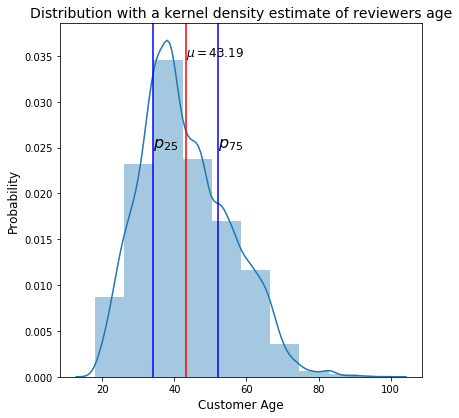

In [6]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.distplot(df_review.Age, bins=10)
_ = plt.axvline(mean_age, color='r')
_ = plt.axvline(p25, color='b')
_ = plt.axvline(p75, color='b')
_ = plt.text(mean_age, 0.035, r'$\mu = 43.19$', fontsize=12)
_ = plt.text(p25, 0.025, r'$p_{25}$', fontsize=16)
_ = plt.text(p75, 0.025, r'$p_{75}$', fontsize=16)
_ = plt.xlabel('Customer Age', size=12)
_ = plt.ylabel('Probability', size=12)
_ = plt.title('Distribution with a kernel density estimate of reviewers age', size=14)

Is this variable normally distributed? The problem with histograms is that the appearance of the distribution depends on the number of bins selected. We'll apply the **normality test Shapiro Wilk**, complementing with Boxplot and Q-Q plots (as we know, when the sample size get large, small deviations from the perfect normality will lead to a significant results and the test rejects the null hypothesis).

Shapiro Wilk is the most powerful test, but it could fail for sample size upper than 5000 datapoints. Therefore, 10% of population (2000 datapoints) are selected randomly and used in the test. 

In [7]:
n = 2000
X = np.random.choice(df_review.Age, n)
statistic, p_value = scp.stats.shapiro(X)
print('p_value: {}'.format(p_value))
if p_value < 0.05:
    print('We reject the null hypothesis. There is evidence that the data is not from a normally distributed population')
else:
    print('We fail to reject the null hypothesis.')

p_value: 6.349226416925074e-19
We reject the null hypothesis. There is evidence that the data is not from a normally distributed population


Let's try another test. Any distribution could be compared with a theorical distribution through the **Kolmogorov Smirnov test**. In this case, we compare the distribution of the whole population with a normal distribution with parameters mu and sigma calculated from the empirical distribution. If p < .05 we can reject the null, and conclude our sample distribution is not identical to a normal distribution.

In [8]:
# Perform test KS test against a normal distribution with mean = 43.198 
# and sd = 12.27
statistic, p_value = scp.stats.kstest(df_review.Age, 'norm', args=(mean_age, std_age))
print('p_value: {}'.format(p_value))
if p_value < 0.05:
    print('We reject the null hypothesis. The distribution is not identical to a normal distribution.')
else:
    print('We fail to reject the null hypothesis.')

p_value: 3.6315115645513653e-153
We reject the null hypothesis. The distribution is not identical to a normal distribution.


Finally, we display a **Quantile-Quantile plot**. This method considers a normally distributed set and the one we are analyzing. If the two distributions being compared are from a common distribution, the points in the plot will approximately lie on a line.

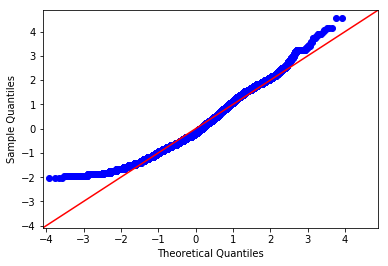

In [9]:
sm.qqplot(df_review.Age, stats.t, fit=True, line="45")
pylab.show()

And, as we can expect, that's not the case.

## Rating Distribution

In [10]:
ratings = df_review.groupby(['Rating']).count()['Clothing ID'].reset_index()
ratings['percent'] = 100*ratings['Clothing ID']/ratings['Clothing ID'].sum()

In [11]:
ratings

,Rating,Clothing ID,percent
0,1,842,3.585115
1,2,1565,6.663544
2,3,2871,12.224304
3,4,5077,21.617134
4,5,13131,55.909904


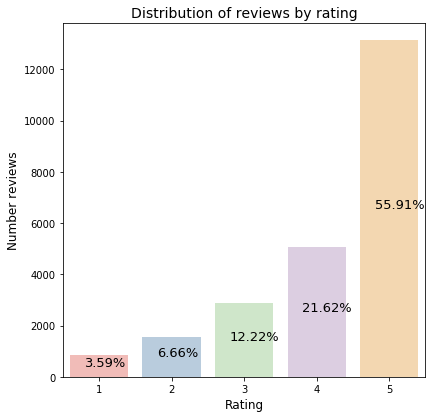

In [12]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=ratings.Rating, y = ratings['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Rating', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by rating', size=14)

for i in range(len(ratings)):
    _ = plt.text(ratings.Rating[i]-1.2, 
                 ratings['Clothing ID'][i]/2, 
                 str(round(ratings.percent[i], 2))+'%', 
                 fontsize=13)

In [13]:
df_sampleRating = df_review.groupby('Rating').apply(lambda x: x.sample(n=800)).reset_index(drop = True)

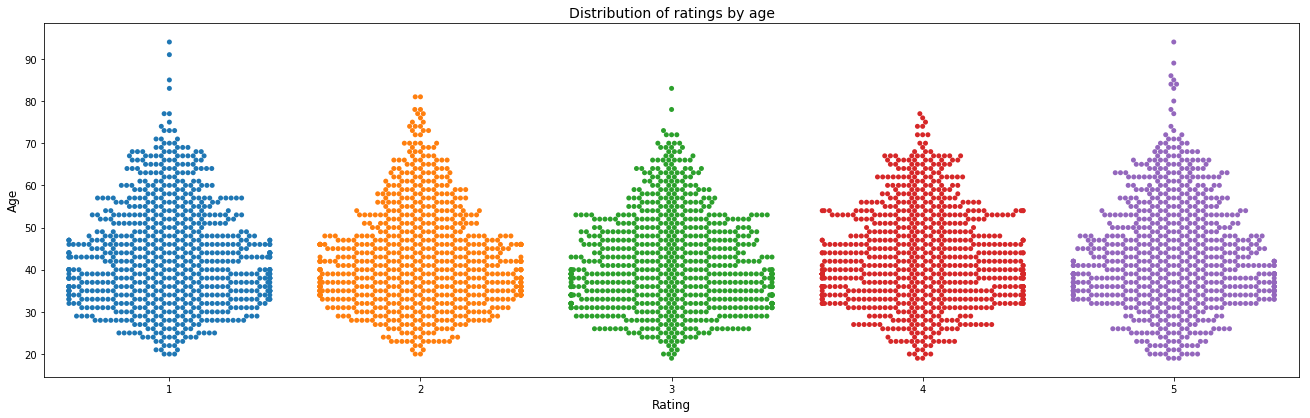

In [14]:
_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Rating", data=df_sampleRating)
_ = plt.xlabel('Rating', size=12)
_ = plt.ylabel('Age', size=12)
_ = plt.title('Distribution of ratings by age', size=14)

In [15]:
df_sample = df_review.sample(frac=0.05, random_state=1)

In [16]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1174 entries, 8061 to 4906
Data columns (total 10 columns):
Clothing ID                1174 non-null int64
Age                        1174 non-null int64
Title                      982 non-null object
Review Text                1135 non-null object
Rating                     1174 non-null int64
Recommended IND            1174 non-null int64
Positive Feedback Count    1174 non-null int64
Division Name              1174 non-null object
Department Name            1174 non-null object
Class Name                 1174 non-null object
dtypes: int64(5), object(5)
memory usage: 100.9+ KB


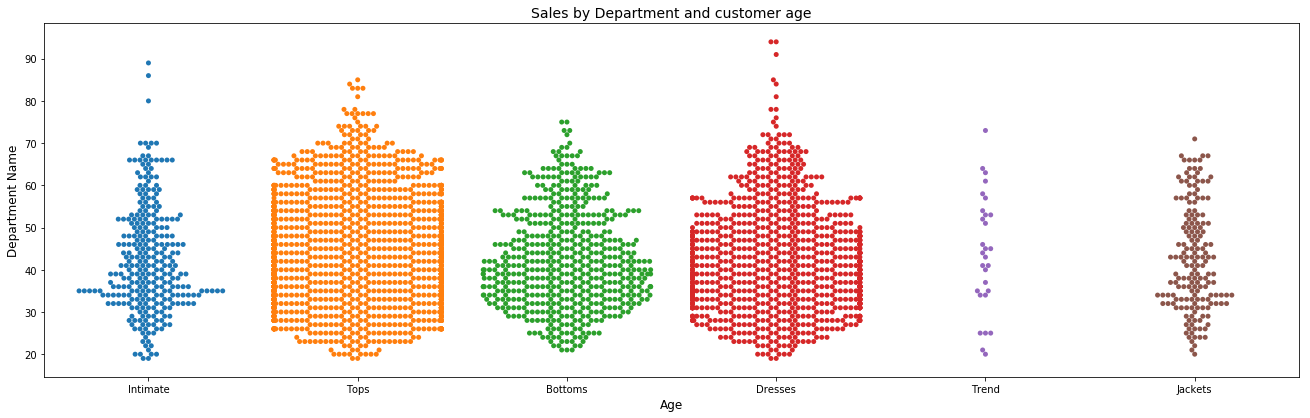

In [17]:
_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Department Name", data=df_sampleRating)
_ = plt.xlabel('Age', size=12)
_ = plt.ylabel('Department Name', size=12)
_ = plt.title('Sales by Department and customer age', size=14)

In [18]:
df_review.groupby('Department Name').count()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name
Department Name,,,,,,,,,
Bottoms,3799,3799,3184,3662,3799,3799,3799,3799,3799
Dresses,6319,6319,5372,6145,6319,6319,6319,6319,6319
Intimate,1735,1735,1408,1653,1735,1735,1735,1735,1735
Jackets,1032,1032,879,1002,1032,1032,1032,1032,1032
Tops,10468,10468,8713,10048,10468,10468,10468,10468,10468
Trend,119,119,107,118,119,119,119,119,119


In [19]:
department = df_review.groupby(['Department Name']).count()['Clothing ID'].reset_index()
department['percent'] = 100*department['Clothing ID']/department['Clothing ID'].sum()

In [20]:
department

,Department Name,Clothing ID,percent
0,Bottoms,3799,16.185242
1,Dresses,6319,26.921438
2,Intimate,1735,7.391786
3,Jackets,1032,4.396728
4,Tops,10468,44.597819
5,Trend,119,0.506987


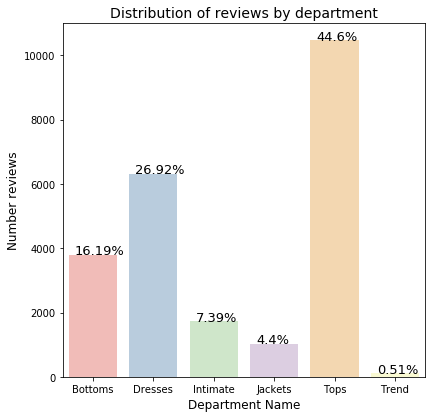

In [21]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=department['Department Name'], y = department['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Department Name', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by department', size=14)

for i in range(len(department)):
    _ = plt.text(i-0.3, 
                 department['Clothing ID'][i], 
                 str(round(department.percent[i], 2))+'%', 
                 fontsize=13)

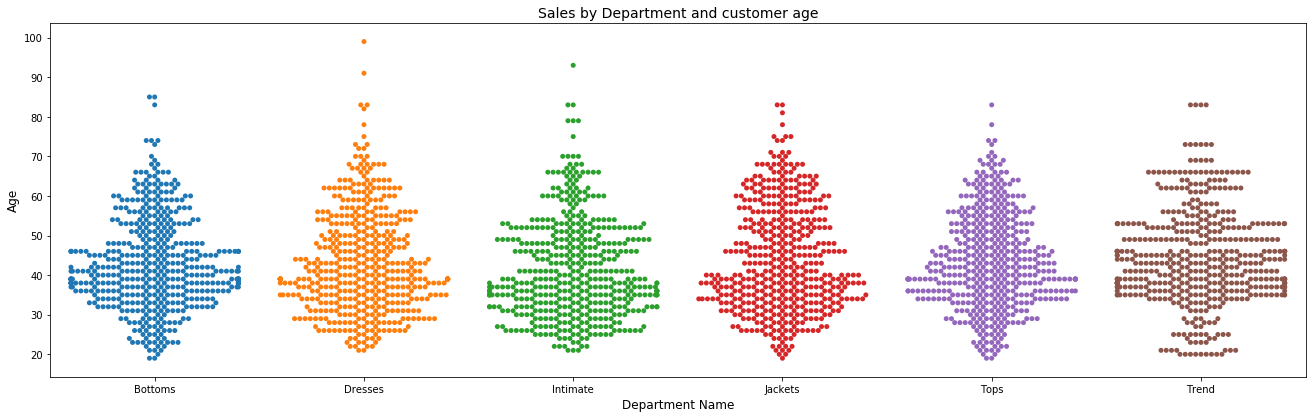

In [22]:
df_sampleDepto = df_review.groupby('Department Name').apply(lambda x: x.sample(n=500, replace=True)).reset_index(drop = True)

_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Department Name", data=df_sampleDepto)
_ = plt.ylabel('Age', size=12)
_ = plt.xlabel('Department Name', size=12)
_ = plt.title('Sales by Department and customer age', size=14)

In [23]:
df_review.groupby(['Department Name', 'Division Name']).count()

Clothing ID   Age  Title  Review Text  Rating  \
Department Name Division Name                                                   
Bottoms         General                2542  2542   2121         2447    2542   
                General Petite         1257  1257   1063         1215    1257   
Dresses         General                3730  3730   3166         3619    3730   
                General Petite         2589  2589   2206         2526    2589   
Intimate        General Petite          233   233    188          227     233   
                Initmates              1502  1502   1220         1426    1502   
Jackets         General                 645   645    547          624     645   
                General Petite          387   387    332          378     387   
Tops            General                6837  6837   5743         6580    6837   
                General Petite         3631  3631   2970         3468    3631   
Trend           General                  96    96     88           95      96   
                General Petite           23    23     19           23      23   

                                Recommended IND  Positive Feedback Count  \
Department Name Division Name                                              
Bottoms         General                    2542                     2542   
                General Petite             1257                     1257   
Dresses         General                    3730                     3730   
                General Petite             2589                     2589   
Intimate        General Petite              233                      233   
                Initmates                  1502                     1502   
Jackets         General                     645                      645   
                General Petite              387                      387   
Tops            General                    6837                     6837   
                General Petite             3631                     3631   
Trend           General                      96                       96   
                General Petite               23                       23   

                                Class Name  
Department Name Division Name               
Bottoms         General               2542  
                General Petite        1257  
Dresses         General               3730  
                General Petite        2589  
Intimate        General Petite         233  
                Initmates             1502  
Jackets         General                645  
                General Petite         387  
Tops            General               6837  
                General Petite        3631  
Trend           General                 96  
                General Petite          23

## Recommended IND and Positive feedback

In [ ]:
df_review.groupby(['Recommended IND']).count()['Clothing ID'].reset_index()